# Flatiron Health mPC: Strict trials with GBM crude 

***OBJECTIVE:*** **Inclusion criteria for trials in other notebooks were relaxed to allow for as many patients to be included as reasonably possible. In this notebook, inclusion criteria for the trials will be followed as closely as possible. Patients included in our trials will next be risk stratified using the gradient boosted model with crude imputation into 1 of 3 risk groups: high (top tertile), medium (middle tertile), and low (bottom tertile). Inverse-probability treatment weighted survival analysis will then be performed across these risk groups to get real-world estimates of survival while adjusting for measured confounders.** 
** 

***OUTLINE:***
1. **Identify patients with exclusion criteria:**
* Cardiac disease (MI or CHF) in the year preceding metastatic diagnosis 
* Viral hepatitis or chronic liver disease in the year preceding metastatic diagnosis   
* CNS metastasis at time of metastatic diagnosis 
* ECOG >2 at time of metastatic diagnosis
* Organ dysfunction at time of metastatic diagnosis  

2. **In silico trials:**
* CHAARTED
* LATITUDE 

## Part 1: Identify patients with exclusion criteria

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

In [3]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(15141, 15141)

In [4]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(3786, 3786)

In [5]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(18927, 18927)

In [6]:
df.query('cns_met == 0').sample(3)

,PatientID,Gender,race,ethnicity,age,p_type,NStage,MStage,Histology,GleasonScore,...,peritoneum_met,liver_met,other_gi_met,cns_met,bone_met,lymph_met,kidney_bladder_met,other_met,prim_treatment,early_adt
13138,F29A90F4B5808,M,other,unknown,76,COMMUNITY,N1,M1,Adenocarcinoma,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,0.0
6827,FB72D5A6E7368,M,unknown,unknown,85,COMMUNITY,Unknown / Not documented,M1,"Prostate cancer, NOS",Unknown / Not documented,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,0.0
1611,FE0663B8E266B,M,black,unknown,61,COMMUNITY,Unknown / Not documented,Unknown / Not documented,Adenocarcinoma,8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,unknown,1.0


### 1. Cardiac disease (CHF or MI) in the preceding 6 months 

In [7]:
diagnosis = pd.read_csv('Diagnosis.csv')

In [8]:
diagnosis = diagnosis[diagnosis['PatientID'].isin(df['PatientID'])]       

In [9]:
diagnosis.loc[:, 'DiagnosisDate'] = pd.to_datetime(diagnosis['DiagnosisDate'])

In [10]:
enhanced_met = pd.read_csv('Enhanced_MetProstate.csv')

In [11]:
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

In [12]:
row_ID(diagnosis)

(605074, 18927)

In [13]:
diagnosis = pd.merge(diagnosis, enhanced_met[['PatientID', 'MetDiagnosisDate']], on = 'PatientID', how = 'left')

In [14]:
row_ID(diagnosis)

(605074, 18927)

In [15]:
diagnosis.loc[:, 'date_diff'] = (diagnosis['DiagnosisDate'] - diagnosis['MetDiagnosisDate']).dt.days

In [16]:
diagnosis.loc[:, 'diagnosis_code'] = diagnosis['DiagnosisCode'].replace('\.', '', regex = True)

In [17]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_9 = (
    diagnosis
    .query('date_diff <= 30 and date_diff > -365')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [18]:
cardiac_9_IDs = (
    diagnosis_9[diagnosis_9['diagnosis_code'].str.match('428|'
                                                        '410')].PatientID.unique())

In [19]:
len(cardiac_9_IDs)

15

In [20]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_10 = (
    diagnosis
    .query('date_diff <= 30 and date_diff > -365')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [21]:
cardiac_10_IDs = (
    diagnosis_10[diagnosis_10['diagnosis_code'].str.match('I50|'
                                                          'I21')].PatientID.unique())

In [22]:
len(cardiac_10_IDs)

195

In [23]:
cardiac_IDs = np.unique(np.concatenate([cardiac_9_IDs, cardiac_10_IDs]))

In [24]:
len(cardiac_IDs)

210

### 2. Viral hepatitis and chronic liver disease 

In [25]:
liv_9_IDs = (
    diagnosis_9[diagnosis_9['diagnosis_code'].str.match('070|'
                                                        '571')].PatientID.unique())

In [26]:
len(liv_9_IDs)

18

In [27]:
liv_10_IDs = (
    diagnosis_10[diagnosis_10['diagnosis_code'].str.match('B1[56789]|'
                                                          'K7[0234]')].PatientID.unique())

In [28]:
len(liv_10_IDs)

65

In [29]:
liv_IDs = np.unique(np.concatenate([liv_9_IDs, liv_10_IDs]))

In [30]:
len(liv_IDs)

82

In [31]:
del diagnosis
del diagnosis_10
del diagnosis_9
del enhanced_met

## Part 2: In-silico trials 

### Import packages and create necessary functions

In [32]:
import numpy as np
import pandas as pd

from scipy import stats

from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier, SurvivalData

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from matplotlib.lines import Line2D   

In [33]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

In [34]:
cutoff = pd.read_csv('risk_cutoff_prostate.csv', index_col = 0)

### CHAARTED: docetaxel vs. ADT in metastatic, castration-sensitive prostate cancer  

**INCLUSION**
* Untreated metastatic prostate cancer, except up to 4 months of ADT 
* Castration-sensitive
* Received ADT or docetaxel plus ADT
* No active cardiac disease in the year preceding metastatic diagnosis 
* ECOG is not 3 or 4 at time of metastatic diagnosis 
* Adequate organ function at time of mestastatic diagnosis  

#### ADT

In [35]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

18927

In [36]:
df_full.reset_index(inplace = True)

In [37]:
adt = pd.read_csv('Enhanced_MetPC_ADT.csv')

In [38]:
adt = (
    adt[adt['PatientID'].isin(df_full['PatientID'])]
    .query('TreatmentSetting == "Advanced"')
)

In [39]:
row_ID(adt)

(17863, 17863)

In [40]:
adt.loc[:, 'StartDate'] = pd.to_datetime(adt['StartDate'])

In [41]:
adt = adt.rename(columns = {'StartDate': 'StartDate_adt'})

In [42]:
df_full = pd.merge(df_full, adt[['PatientID', 'StartDate_adt']], on = 'PatientID', how = 'left')

In [43]:
row_ID(df_full)

(18927, 18927)

In [44]:
enhanced_met = pd.read_csv('Enhanced_MetProstate.csv')

In [45]:
enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(df_full['PatientID'])]

In [46]:
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

In [47]:
enhanced_met.loc[:, 'CRPCDate'] = pd.to_datetime(enhanced_met['CRPCDate'])

In [48]:
df_full = pd.merge(df_full, enhanced_met[['PatientID', 'MetDiagnosisDate', 'CRPCDate']], on = 'PatientID', how = 'left')

In [49]:
row_ID(df_full)

(18927, 18927)

In [50]:
# Find all that start ADT within -120 to +90 days of metastatic diagnosis 
chaarted_adt = (
    df_full
    .assign(adt_diff = (df_full['StartDate_adt'] - df_full['MetDiagnosisDate']).dt.days)
    .query('adt_diff >= -120 and adt_diff <= 90')
)

In [51]:
# Find all that have missing CPRC date or date is >90 after metastatic diagnosis 
chaarted_adt = (
    chaarted_adt
    .assign(crpc_diff = (chaarted_adt['CRPCDate'] - chaarted_adt['MetDiagnosisDate']).dt.days)
    .query('crpc_diff > 90 or CRPCDate.isna()', engine = 'python')
)

In [52]:
row_ID(chaarted_adt)

(10475, 10475)

In [53]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [54]:
zero = (
    line_therapy.query('LineNumber == 0')
    .PatientID
)

In [55]:
# Exclude patients with missing treatment information (ie, LineNumber == 0)
chaarted_adt = chaarted_adt[~chaarted_adt.PatientID.isin(zero)]

In [56]:
row_ID(chaarted_adt)

(10117, 10117)

In [57]:
line_therapy_cont = line_therapy.query('LineSetting != "nmCRPC"')

In [58]:
# List of FDA approved drugs for mPC as of July 2023. Clinical study drug is also included. 
fda_yes = [
    'Abiraterone',
    'Apalutamide',
    'Cabazitaxel',
    'Carboplatin',
    'Cisplatin',
    'Darolutamide',
    'Docetaxel',
    'Enzalutamide',
    'Mitoxantrone',
    'Olaparib',
    'Oxaliplatin',
    'Paclitaxel',
    'Pembrolizumab',
    'Radium-223',
    'Rucaparib',
    'Sipuleucel-T',
    'Clinical Study Drug'
]

In [59]:
line_therapy_cont = line_therapy_cont[line_therapy_cont['LineName'].str.contains('|'.join(fda_yes))]

In [60]:
line_therapy_cont = (
    line_therapy_cont
    .sort_values(by = ['PatientID', 'StartDate'], ascending = [True, True])
)

In [61]:
line_therapy_cont['line_number'] = (
    line_therapy_cont.groupby('PatientID')['LineNumber'].cumcount()+1
)

In [62]:
# First line therapy is in castrate-resistant setting 
fl_crpc = (
    line_therapy_cont[line_therapy_cont.PatientID.isin(chaarted_adt.PatientID)]
    .query('line_number == 1 & LineSetting == "mCRPC"')
    .PatientID
)

In [63]:
# Never received therapy other than ADT
notrt_adt = (
    chaarted_adt[~chaarted_adt.PatientID.isin(line_therapy_cont.PatientID)]
    .PatientID
)

In [64]:
adt_IDs = np.concatenate((fl_crpc, notrt_adt))

In [65]:
len(adt_IDs)

6218

In [66]:
chaarted_adt = chaarted_adt[chaarted_adt.PatientID.isin(adt_IDs)]

In [67]:
chaarted_adt.loc[:,'adt_dotx'] = 0

In [68]:
row_ID(chaarted_adt)

(6218, 6218)

In [69]:
chaarted_adt.sample(3)

,PatientID,Gender,race,ethnicity,age,p_type,NStage,MStage,Histology,GleasonScore,...,other_met,prim_treatment,early_adt,risk_score,StartDate_adt,MetDiagnosisDate,CRPCDate,adt_diff,crpc_diff,adt_dotx
17094,F04F6265DA588,M,white,unknown,73,COMMUNITY,N0,M1b,Adenocarcinoma,9,...,0.0,unknown,0.0,-0.632800,2020-06-25,2020-05-19,2021-08-31,37.0,469.0,0
5810,F9167BE5C621B,M,white,unknown,77,COMMUNITY,Unknown / Not documented,Unknown / Not documented,Adenocarcinoma,4 + 3 = 7,...,0.0,radiation,0.0,-0.673186,2014-04-07,2014-04-02,NaT,5.0,NaN,0
9652,FEFF9EE32FAA3,M,white,unknown,57,COMMUNITY,N1,M1a,Adenocarcinoma,8,...,0.0,unknown,0.0,-0.836685,2019-12-09,2019-10-24,NaT,46.0,NaN,0


#### Docetaxel + ADT

In [70]:
# Find those that start ADT within -120 to 90 days of metastaic diagnosis 
chaarted_dotx = (
    df_full
    .assign(adt_diff = (df_full['StartDate_adt'] - df_full['MetDiagnosisDate']).dt.days)
    .query('adt_diff >= -120 and adt_diff <= 90')
)

In [71]:
# Find all that have missing CPRC date or date is >90 days metastatic diagnosis 
chaarted_dotx = (
    chaarted_dotx
    .assign(crpc_diff = (chaarted_dotx['CRPCDate'] - chaarted_dotx['MetDiagnosisDate']).dt.days)
    .query('crpc_diff > 90 or CRPCDate.isna()', engine = 'python')
)

In [72]:
row_ID(chaarted_dotx)

(10475, 10475)

In [73]:
# Find start time of first line of mHSPC therapy. 
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(chaarted_dotx['PatientID'])]
    .query('LineSetting == "mHSPC"')
    .sort_values(by = ['PatientID', 'StartDate'], ascending = [True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .rename(columns = {'StartDate': 'StartDate_dotx'})
)

In [74]:
row_ID(line_therapy_fl)

(4042, 4042)

In [75]:
line_therapy_fl.loc[:, 'StartDate_dotx'] = pd.to_datetime(line_therapy_fl['StartDate_dotx'])

In [76]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('Docetaxel')].LineName.value_counts().head(10)

Docetaxel                                         1363
Abiraterone,Docetaxel                               27
Carboplatin,Docetaxel                               12
Clinical Study Drug,Docetaxel                       11
Darolutamide,Docetaxel                               9
Docetaxel,Enzalutamide                               6
Carboplatin,Docetaxel,Estramustine                   5
Docetaxel,Ketoconazole                               3
Apalutamide,Docetaxel                                2
Carboplatin,Docetaxel,Estramustine,Thalidomide       2
Name: LineName, dtype: int64

In [77]:
line_dotx = line_therapy_fl.query('LineName == "Docetaxel"')

In [78]:
row_ID(line_dotx)

(1363, 1363)

In [79]:
chaarted_dotx = pd.merge(chaarted_dotx, line_dotx[['PatientID', 'StartDate_dotx']], on = 'PatientID', how = 'left')

In [80]:
row_ID(chaarted_dotx)

(10475, 10475)

In [81]:
# Find all patients that start enzalutamide within 180 days of metastatic diagnosis
chaarted_dotx = (
    chaarted_dotx
    .assign(fl_diff = (chaarted_dotx['StartDate_dotx'] - chaarted_dotx['StartDate_adt']).dt.days)
    .query('fl_diff >= -90 and fl_diff <= 90')
)

In [82]:
len(chaarted_dotx)

1179

In [83]:
chaarted_dotx.sample(3)

,PatientID,Gender,race,ethnicity,age,p_type,NStage,MStage,Histology,GleasonScore,...,prim_treatment,early_adt,risk_score,StartDate_adt,MetDiagnosisDate,CRPCDate,adt_diff,crpc_diff,StartDate_dotx,fl_diff
5806,F6A590ABDEE55,M,white,unknown,62,COMMUNITY,Unknown / Not documented,M1,Adenocarcinoma,Unknown / Not documented,...,unknown,0.0,-0.714950,2021-01-14,2021-01-04,NaT,10.0,NaN,2021-01-22,8.0
2431,FAD0720F6BB6A,M,white,unknown,68,COMMUNITY,NX,M1b,Adenocarcinoma,Unknown / Not documented,...,unknown,0.0,-0.298820,2015-11-13,2015-11-04,2016-09-16,9.0,317.0,2015-11-13,0.0
2747,FFF43B2EBDDCE,M,unknown,unknown,56,COMMUNITY,Unknown / Not documented,M1,Adenocarcinoma,9,...,unknown,0.0,-0.241554,2018-12-07,2018-11-20,2019-08-20,17.0,273.0,2018-12-12,5.0


In [84]:
chaarted_dotx.loc[:,'adt_dotx'] = 1

In [85]:
chaarted = pd.concat([chaarted_adt, chaarted_dotx], ignore_index = True)

In [86]:
row_ID(chaarted)

(7397, 7397)

In [87]:
chaarted.adt_dotx.value_counts(dropna = False)

0    6218
1    1179
Name: adt_dotx, dtype: int64

In [88]:
chaarted.sample(3)

,PatientID,Gender,race,ethnicity,age,p_type,NStage,MStage,Histology,GleasonScore,...,early_adt,risk_score,StartDate_adt,MetDiagnosisDate,CRPCDate,adt_diff,crpc_diff,adt_dotx,StartDate_dotx,fl_diff
1250,FCE28AD4285F9,M,black,unknown,68,COMMUNITY,Unknown / Not documented,M1,"Prostate cancer, NOS",Unknown / Not documented,...,0.0,0.108742,2020-07-09,2020-06-24,2021-12-29,15.0,553.0,0,NaT,NaN
4846,F9033669B6D8F,M,white,unknown,78,COMMUNITY,Unknown / Not documented,M1,Adenocarcinoma,4 + 3 = 7,...,0.0,-0.279877,2017-03-29,2017-02-21,NaT,36.0,NaN,0,NaT,NaN
1747,FE287C1B75549,M,white,unknown,60,COMMUNITY,Unknown / Not documented,M1,Adenocarcinoma,Unknown / Not documented,...,0.0,0.997241,2016-11-15,2016-10-25,2017-04-11,21.0,168.0,0,NaT,NaN


#### Time from ADT treatment to death or censor 

In [89]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [90]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [91]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [92]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [93]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(18927, 18927)

In [94]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [95]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [96]:
len(mortality)

18927

In [97]:
chaarted = pd.merge(chaarted, mortality, on = 'PatientID', how = 'left')

In [98]:
row_ID(chaarted)

(7397, 7397)

In [99]:
conditions = [
    (chaarted['death_status'] == 1),
    (chaarted['death_status'] == 0)]

choices = [
    (chaarted['death_date'] - chaarted['StartDate_adt']).dt.days,
    (chaarted['last_activity'] - chaarted['StartDate_adt']).dt.days]

chaarted.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

chaarted = chaarted.query('timerisk_treatment >= 0')

#### Patient count 

In [100]:
row_ID(chaarted)

(7397, 7397)

In [101]:
# Exclude those with active cardiac disease in the year preceding metastatic diagnosis 
chaarted = chaarted[~chaarted['PatientID'].isin(cardiac_IDs)]

In [102]:
# Exclude those with ECOG 3 or 4 at time of metastatic diagnosis 
chaarted = chaarted.query('ecog_diagnosis != "3.0" and ecog_diagnosis != "4.0"')

In [103]:
# Exclude those with abnormal organ function at time of metastatic diagnosis 
chaarted = (
    chaarted
    .query('creatinine_diag < 2 or creatinine_diag_na == 1')
    .query('hemoglobin_diag > 9 or hemoglobin_diag_na == 1')
    .query('total_bilirubin_diag < 3 or total_bilirubin_diag_na == 1')
)

In [104]:
row_ID(chaarted)

(6812, 6812)

In [105]:
low_cutoff_chaarted = cutoff.loc['chaarted'].low

In [106]:
high_cutoff_chaarted = cutoff.loc['chaarted'].high

In [107]:
print('Docetaxel + ADT:',  chaarted.query('adt_dotx == 1').shape[0])
print('High risk:', chaarted.query('adt_dotx == 1').query('risk_score >= @high_cutoff_chaarted').shape[0])
print('Med risk:', chaarted.query('adt_dotx == 1').query('risk_score < @high_cutoff_chaarted and risk_score > @low_cutoff_chaarted').shape[0])
print('Low risk:', chaarted.query('adt_dotx == 1').query('risk_score <= @low_cutoff_chaarted').shape[0])

Docetaxel + ADT: 1088
High risk: 240
Med risk: 410
Low risk: 438


In [108]:
print('ADT:',  chaarted.query('adt_dotx == 0').shape[0])
print('High risk:', chaarted.query('adt_dotx == 0').query('risk_score >= @high_cutoff_chaarted').shape[0])
print('Med risk:', chaarted.query('adt_dotx == 0').query('risk_score < @high_cutoff_chaarted and risk_score > @low_cutoff_chaarted').shape[0])
print('Low risk:', chaarted.query('adt_dotx == 0').query('risk_score <= @low_cutoff_chaarted').shape[0])

ADT: 5724
High risk: 1708
Med risk: 2002
Low risk: 2014


#### Survival curves with covariate balancing 

In [109]:
chaarted = chaarted.set_index('PatientID')

In [110]:
chaarted['met_cat'] = pd.cut(chaarted['met_year'],
                             bins = [2010, 2015, float('inf')],
                             labels = ['11-15', '16-22'])

In [111]:
conditions = [
    ((chaarted['ecog_diagnosis'] == "1.0") | (chaarted['ecog_diagnosis'] == "0.0")),  
    ((chaarted['ecog_diagnosis'] == "2.0") | (chaarted['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

chaarted['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [112]:
chaarted_iptw = chaarted.filter(items = ['death_status',
                                         'timerisk_treatment',
                                         'adt_dotx',
                                         'age',
                                         'race',
                                         'p_type',
                                         'met_cat',
                                         'delta_met_diagnosis',
                                         'commercial',
                                         'medicare',
                                         'medicaid',
                                         'ecog_2',
                                         'prim_treatment',
                                         'PSAMetDiagnosis',
                                         'risk_score'])

In [113]:
chaarted_iptw.dtypes

death_status               bool
timerisk_treatment      float64
adt_dotx                  int64
age                       int64
race                     object
p_type                   object
met_cat                category
delta_met_diagnosis       int64
commercial              float64
medicare                float64
medicaid                float64
ecog_2                   object
prim_treatment           object
PSAMetDiagnosis         float64
risk_score              float64
dtype: object

In [114]:
to_be_categorical = list(chaarted_iptw.select_dtypes(include = ['object']).columns)

In [115]:
to_be_categorical

['race', 'p_type', 'ecog_2', 'prim_treatment']

In [116]:
to_be_categorical.append('met_cat')

In [117]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    chaarted_iptw[x] = chaarted_iptw[x].astype('category')

In [118]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis', 'PSAMetDiagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [119]:
# List of categorical features.
categorical_features = list(chaarted_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [120]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [121]:
chaarted_iptw_low = (
    chaarted_iptw
    .query('risk_score <= @low_cutoff_chaarted')
    .drop(columns = ['risk_score']))

chaarted_iptw_med = (
    chaarted_iptw
    .query('risk_score < @high_cutoff_chaarted and risk_score > @low_cutoff_chaarted')
    .drop(columns = ['risk_score']))

chaarted_iptw_high = (
    chaarted_iptw
    .query('risk_score >= @high_cutoff_chaarted')
    .drop(columns = ['risk_score']))

chaarted_iptw_all = (
    chaarted_iptw
    .drop(columns = ['risk_score']))

In [122]:
chaarted_low_x = preprocessor.fit_transform(chaarted_iptw_low.filter(items = ['age',
                                                                              'race',
                                                                              'p_type',
                                                                              'delta_met_diagnosis',
                                                                              'met_cat',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ecog_2',
                                                                              'prim_treatment',
                                                                              'PSAMetDiagnosis']))

chaarted_med_x = preprocessor.fit_transform(chaarted_iptw_med.filter(items = ['age',
                                                                              'race',
                                                                              'p_type',
                                                                              'delta_met_diagnosis',
                                                                              'met_cat',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ecog_2',
                                                                              'prim_treatment',
                                                                              'PSAMetDiagnosis']))

chaarted_high_x = preprocessor.fit_transform(chaarted_iptw_high.filter(items = ['age',
                                                                                'race',
                                                                                'p_type',
                                                                                'delta_met_diagnosis',
                                                                                'met_cat',
                                                                                'commercial',
                                                                                'medicare',
                                                                                'medicaid',
                                                                                'ecog_2',
                                                                                'prim_treatment',
                                                                                'PSAMetDiagnosis']))

chaarted_all_x = preprocessor.fit_transform(chaarted_iptw_all.filter(items = ['age',
                                                                              'race',
                                                                              'p_type',
                                                                              'delta_met_diagnosis',
                                                                              'met_cat',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ecog_2',
                                                                              'prim_treatment',
                                                                              'PSAMetDiagnosis']))

In [123]:
lr_chaarted_low = LogisticRegression(max_iter = 1000)
lr_chaarted_low.fit(chaarted_low_x, chaarted_iptw_low['adt_dotx'])

LogisticRegression(max_iter=1000)

In [124]:
lr_chaarted_med = LogisticRegression(max_iter = 1000)
lr_chaarted_med.fit(chaarted_med_x, chaarted_iptw_med['adt_dotx'])

LogisticRegression(max_iter=1000)

In [125]:
lr_chaarted_high = LogisticRegression(max_iter = 1000)
lr_chaarted_high.fit(chaarted_high_x, chaarted_iptw_high['adt_dotx'])

LogisticRegression(max_iter=1000)

In [126]:
lr_chaarted_all = LogisticRegression(max_iter = 1000)
lr_chaarted_all.fit(chaarted_all_x, chaarted_iptw_all['adt_dotx'])

LogisticRegression(max_iter=1000)

In [127]:
pred_low = lr_chaarted_low.predict_proba(chaarted_low_x)
pred_med = lr_chaarted_med.predict_proba(chaarted_med_x)
pred_high = lr_chaarted_high.predict_proba(chaarted_high_x)
pred_all = lr_chaarted_all.predict_proba(chaarted_all_x)

In [128]:
chaarted_iptw_low['ps'] = pred_low[:, 1]
chaarted_iptw_med['ps'] = pred_med[:, 1]
chaarted_iptw_high['ps'] = pred_high[:, 1]
chaarted_iptw_all['ps'] = pred_all[:, 1]

In [129]:
chaarted_iptw_low['weight'] = (
    np.where(chaarted_iptw_low['adt_dotx'] == 1, 1/chaarted_iptw_low['ps'], 1/(1 - chaarted_iptw_low['ps'])))

chaarted_iptw_med['weight'] = (
    np.where(chaarted_iptw_med['adt_dotx'] == 1, 1/chaarted_iptw_med['ps'], 1/(1 - chaarted_iptw_med['ps'])))

chaarted_iptw_high['weight'] = (
    np.where(chaarted_iptw_high['adt_dotx'] == 1, 1/chaarted_iptw_high['ps'], 1/(1 - chaarted_iptw_high['ps'])))

chaarted_iptw_all['weight'] = (
    np.where(chaarted_iptw_all['adt_dotx'] == 1, 1/chaarted_iptw_all['ps'], 1/(1 - chaarted_iptw_all['ps'])))

In [130]:
# Low KM curves
kmf_low_dotx_chaarted_iptw = KaplanMeierFitter()
kmf_low_adt_chaarted_iptw = KaplanMeierFitter()

kmf_low_dotx_chaarted_iptw.fit(
    chaarted_iptw_low.query('adt_dotx == 1').timerisk_treatment/30,
    chaarted_iptw_low.query('adt_dotx == 1').death_status,
    weights = chaarted_iptw_low.query('adt_dotx == 1')['weight'])

kmf_low_adt_chaarted_iptw.fit(
    chaarted_iptw_low.query('adt_dotx == 0').timerisk_treatment/30,
    chaarted_iptw_low.query('adt_dotx == 0').death_status,
    weights = chaarted_iptw_low.query('adt_dotx == 0')['weight'])

# Med KM curves
kmf_med_dotx_chaarted_iptw = KaplanMeierFitter()
kmf_med_adt_chaarted_iptw = KaplanMeierFitter()

kmf_med_dotx_chaarted_iptw.fit(
    chaarted_iptw_med.query('adt_dotx == 1').timerisk_treatment/30,
    chaarted_iptw_med.query('adt_dotx == 1').death_status,
    weights = chaarted_iptw_med.query('adt_dotx == 1')['weight'])

kmf_med_adt_chaarted_iptw.fit(
    chaarted_iptw_med.query('adt_dotx == 0').timerisk_treatment/30,
    chaarted_iptw_med.query('adt_dotx == 0').death_status,
    weights = chaarted_iptw_med.query('adt_dotx == 0')['weight'])

# High KM curves 
kmf_high_dotx_chaarted_iptw = KaplanMeierFitter()
kmf_high_adt_chaarted_iptw = KaplanMeierFitter()

kmf_high_dotx_chaarted_iptw.fit(
    chaarted_iptw_high.query('adt_dotx == 1').timerisk_treatment/30,
    chaarted_iptw_high.query('adt_dotx == 1').death_status,
    weights = chaarted_iptw_high.query('adt_dotx == 1')['weight'])

kmf_high_adt_chaarted_iptw.fit(
    chaarted_iptw_high.query('adt_dotx == 0').timerisk_treatment/30,
    chaarted_iptw_high.query('adt_dotx == 0').death_status,
    weights = chaarted_iptw_high.query('adt_dotx == 0')['weight'])

# All KM curves 
kmf_all_dotx_chaarted_iptw = KaplanMeierFitter()
kmf_all_adt_chaarted_iptw = KaplanMeierFitter()

kmf_all_dotx_chaarted_iptw.fit(
    chaarted_iptw_all.query('adt_dotx == 1').timerisk_treatment/30,
    chaarted_iptw_all.query('adt_dotx == 1').death_status,
    weights = chaarted_iptw_all.query('adt_dotx == 1')['weight'])

kmf_all_adt_chaarted_iptw.fit(
    chaarted_iptw_all.query('adt_dotx == 0').timerisk_treatment/30,
    chaarted_iptw_all.query('adt_dotx == 0').death_status,
    weights = chaarted_iptw_all.query('adt_dotx == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 6828.31 total observations, 3159.02 right-censored observations>

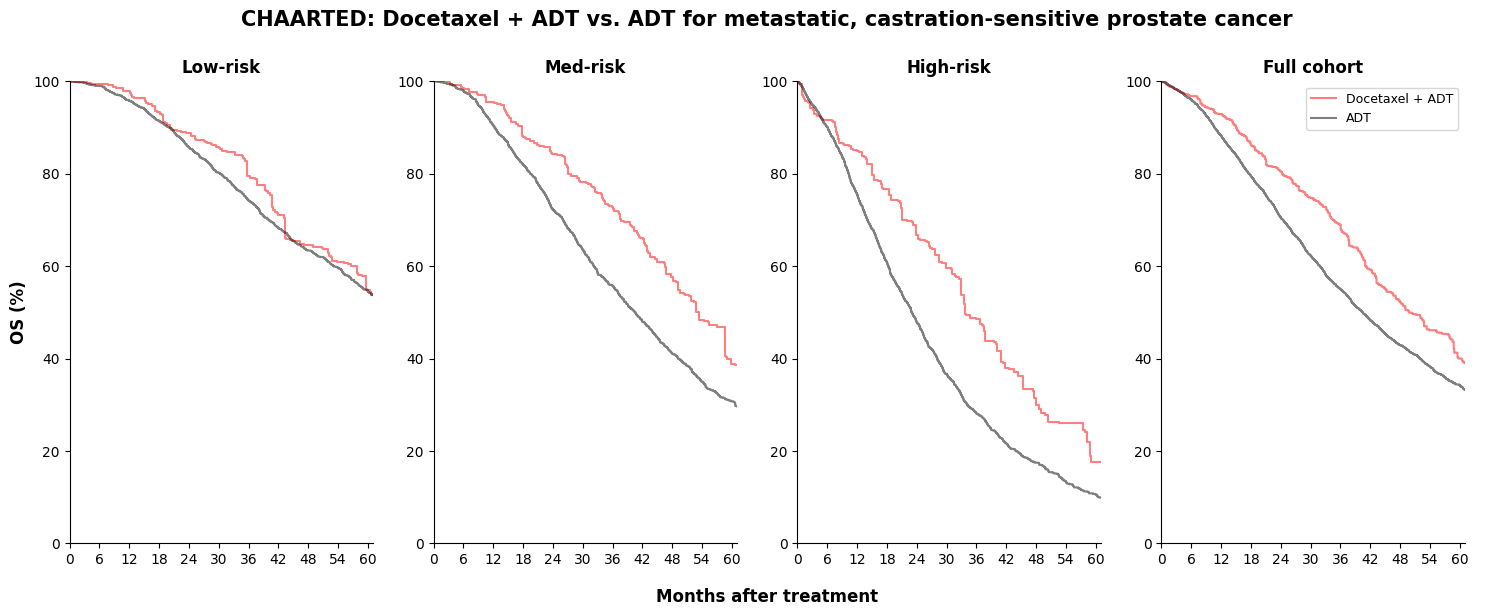

In [131]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_dotx_chaarted_iptw.timeline, kmf_low_dotx_chaarted_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_adt_chaarted_iptw.timeline, kmf_low_adt_chaarted_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_dotx_chaarted_iptw.timeline, kmf_med_dotx_chaarted_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_adt_chaarted_iptw.timeline, kmf_med_adt_chaarted_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_dotx_chaarted_iptw.timeline, kmf_high_dotx_chaarted_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_adt_chaarted_iptw.timeline, kmf_high_adt_chaarted_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_dotx_chaarted_iptw.timeline, kmf_all_dotx_chaarted_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Docetaxel + ADT')

plt.step(kmf_all_adt_chaarted_iptw.timeline, kmf_all_adt_chaarted_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'ADT')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CHAARTED: Docetaxel + ADT vs. ADT for metastatic, castration-sensitive prostate cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

### LATITUDE : abiraterone vs. ADT in metastatic, castration-sensitive prostate cancer  

**INCLUSION**
* Untreated metastatic prostate cancer, except up to 3 months of ADT 
* Castration-sensitive
* Received ADT or abiraterone plus ADT
* No active cardiac disease, viral hepatitis, or chronic liver disease in the year preceding metastatic diagnosis
* No CNS metatastasis at time of metastatic diagnosis 
* ECOG is not 3 or 4 at time of metastatic diagnosis 
* Adequate organ function at time of mestastatic diagnosis 

#### ADT

In [132]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

18927

In [133]:
df_full.reset_index(inplace = True)

In [134]:
adt = pd.read_csv('Enhanced_MetPC_ADT.csv')

In [135]:
adt = (
    adt[adt['PatientID'].isin(df_full['PatientID'])]
    .query('TreatmentSetting == "Advanced"')
)

In [136]:
row_ID(adt)

(17863, 17863)

In [137]:
adt.loc[:, 'StartDate'] = pd.to_datetime(adt['StartDate'])

In [138]:
adt = adt.rename(columns = {'StartDate': 'StartDate_adt'})

In [139]:
df_full = pd.merge(df_full, adt[['PatientID', 'StartDate_adt']], on = 'PatientID', how = 'left')

In [140]:
row_ID(df_full)

(18927, 18927)

In [141]:
enhanced_met = pd.read_csv('Enhanced_MetProstate.csv')

In [142]:
enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(df_full['PatientID'])]

In [143]:
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

In [144]:
enhanced_met.loc[:, 'CRPCDate'] = pd.to_datetime(enhanced_met['CRPCDate'])

In [145]:
df_full = pd.merge(df_full, enhanced_met[['PatientID', 'MetDiagnosisDate', 'CRPCDate']], on = 'PatientID', how = 'left')

In [146]:
row_ID(df_full)

(18927, 18927)

In [147]:
# Find all that start ADT within -90 to +90 days of metastatic diagnosis 
latitude_adt = (
    df_full
    .assign(adt_diff = (df_full['StartDate_adt'] - df_full['MetDiagnosisDate']).dt.days)
    .query('adt_diff >= -90 and adt_diff <= 90')
)

In [148]:
# Find all that have missing CPRC date or date is >90 after metastatic diagnosis 
latitude_adt = (
    latitude_adt
    .assign(crpc_diff = (latitude_adt['CRPCDate'] - latitude_adt['MetDiagnosisDate']).dt.days)
    .query('crpc_diff > 90 or CRPCDate.isna()', engine = 'python')
)

In [149]:
row_ID(latitude_adt)

(10397, 10397)

In [150]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [151]:
zero = (
    line_therapy.query('LineNumber == 0')
    .PatientID
)

In [152]:
# Exclude patients with missing treatment information (ie, LineNumber == 0)
latitude_adt = latitude_adt[~latitude_adt.PatientID.isin(zero)]

In [153]:
row_ID(latitude_adt)

(10047, 10047)

In [154]:
line_therapy_cont = line_therapy.query('LineSetting != "nmCRPC"')

In [155]:
# List of FDA approved drugs for mPC as of July 2023. Clinical study drug is also included. 
fda_yes = [
    'Abiraterone',
    'Apalutamide',
    'Cabazitaxel',
    'Carboplatin',
    'Cisplatin',
    'Darolutamide',
    'Docetaxel',
    'Enzalutamide',
    'Mitoxantrone',
    'Olaparib',
    'Oxaliplatin',
    'Paclitaxel',
    'Pembrolizumab',
    'Radium-223',
    'Rucaparib',
    'Sipuleucel-T',
    'Clinical Study Drug'
]

In [156]:
line_therapy_cont = line_therapy_cont[line_therapy_cont['LineName'].str.contains('|'.join(fda_yes))]

In [157]:
line_therapy_cont = (
    line_therapy_cont
    .sort_values(by = ['PatientID', 'StartDate'], ascending = [True, True])
)

In [158]:
line_therapy_cont['line_number'] = (
    line_therapy_cont.groupby('PatientID')['LineNumber'].cumcount()+1
)

In [159]:
# First line therapy is in castrate-resistant setting 
fl_crpc = (
    line_therapy_cont[line_therapy_cont.PatientID.isin(latitude_adt.PatientID)]
    .query('line_number == 1 & LineSetting == "mCRPC"')
    .PatientID
)

In [160]:
# Never received therapy other than ADT
notrt_adt = (
    latitude_adt[~latitude_adt.PatientID.isin(line_therapy_cont.PatientID)]
    .PatientID
)

In [161]:
adt_IDs = np.concatenate((fl_crpc, notrt_adt))

In [162]:
len(adt_IDs)

6167

In [163]:
latitude_adt = latitude_adt[latitude_adt.PatientID.isin(adt_IDs)]

In [164]:
latitude_adt.loc[:,'adt_abi'] = 0

In [165]:
row_ID(latitude_adt)

(6167, 6167)

In [166]:
latitude_adt.sample(3)

,PatientID,Gender,race,ethnicity,age,p_type,NStage,MStage,Histology,GleasonScore,...,other_met,prim_treatment,early_adt,risk_score,StartDate_adt,MetDiagnosisDate,CRPCDate,adt_diff,crpc_diff,adt_abi
13545,FA61D167321FF,M,white,unknown,77,COMMUNITY,NX,M1,Adenocarcinoma,8,...,0.0,unknown,0.0,-0.366532,2014-10-28,2014-09-05,NaT,53.0,NaN,0
5546,FF863A0BB6E20,M,other,unknown,77,COMMUNITY,Unknown / Not documented,M1,Adenocarcinoma,Unknown / Not documented,...,0.0,unknown,0.0,0.984859,2017-12-21,2017-11-21,2018-05-31,30.0,191.0,0
3123,F6D49641A1579,M,white,unknown,75,COMMUNITY,N1,M1c,Adenocarcinoma,Unknown / Not documented,...,0.0,unknown,0.0,1.146700,2014-06-27,2014-05-27,NaT,31.0,NaN,0


#### Treatment arm: Abiraterone + ADT

In [167]:
# Find those that start ADT within -90 to 90 days of metastaic diagnosis 
latitude_abi = (
    df_full
    .assign(adt_diff = (df_full['StartDate_adt'] - df_full['MetDiagnosisDate']).dt.days)
    .query('adt_diff >= -90 and adt_diff <= 90')
)

In [168]:
# Find all that have missing CPRC date or date is >30 days metastatic diagnosis 
latitude_abi = (
    latitude_abi
    .assign(crpc_diff = (latitude_abi['CRPCDate'] - latitude_abi['MetDiagnosisDate']).dt.days)
    .query('crpc_diff > 90 or CRPCDate.isna()', engine = 'python')
)

In [169]:
row_ID(latitude_abi)

(10397, 10397)

In [170]:
# Find start time of first line of mHSPC therapy. 
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(latitude_abi['PatientID'])]
    .query('LineSetting == "mHSPC"')
    .sort_values(by = ['PatientID', 'StartDate'], ascending = [True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .rename(columns = {'StartDate': 'StartDate_abi'})
)

In [171]:
row_ID(line_therapy_fl)

(4022, 4022)

In [172]:
line_therapy_fl.loc[:, 'StartDate_abi'] = pd.to_datetime(line_therapy_fl['StartDate_abi'])

In [173]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('Abiraterone')].LineName.value_counts().head(10)

Abiraterone                             1165
Abiraterone,Docetaxel                     27
Abiraterone,Enzalutamide                   8
Abiraterone,Clinical Study Drug            4
Abiraterone,Apalutamide                    4
Abiraterone,Apalutamide,Enzalutamide       1
Abiraterone,Capecitabine                   1
Abiraterone,Medroxyprogesterone            1
Abiraterone,Fluorouracil                   1
Abiraterone,Tamoxifen                      1
Name: LineName, dtype: int64

In [174]:
line_abi = line_therapy_fl.query('LineName == "Abiraterone"')

In [175]:
row_ID(line_abi)

(1165, 1165)

In [176]:
latitude_abi = pd.merge(latitude_abi, line_abi[['PatientID', 'StartDate_abi']], on = 'PatientID', how = 'left')

In [177]:
row_ID(latitude_abi)

(10397, 10397)

In [178]:
# Find all patients that start abiraterone within 90 days of ADT start
latitude_abi = (
    latitude_abi
    .assign(abi_diff = (latitude_abi['StartDate_abi'] - latitude_abi['StartDate_adt']).dt.days)
    .query('abi_diff >= -90 and abi_diff <= 90')
)

In [179]:
row_ID(latitude_abi)

(876, 876)

In [180]:
latitude_abi.sample(3)

,PatientID,Gender,race,ethnicity,age,p_type,NStage,MStage,Histology,GleasonScore,...,prim_treatment,early_adt,risk_score,StartDate_adt,MetDiagnosisDate,CRPCDate,adt_diff,crpc_diff,StartDate_abi,abi_diff
6097,FBE12C247909D,M,unknown,hispanic_latino,58,COMMUNITY,N1,M1b,Adenocarcinoma,9,...,unknown,0.0,-1.243935,2020-10-09,2020-09-09,NaT,30.0,NaN,2020-11-12,34.0
830,FA50450FDEE22,M,white,unknown,81,COMMUNITY,Unknown / Not documented,M1,Adenocarcinoma,Unknown / Not documented,...,unknown,0.0,1.075722,2021-10-18,2021-09-02,NaT,46.0,NaN,2021-10-18,0.0
1588,F912BCBF6EAE4,M,unknown,unknown,58,COMMUNITY,N0,M1,Adenocarcinoma,9,...,unknown,0.0,-0.513649,2021-09-30,2021-08-25,NaT,36.0,NaN,2021-11-29,60.0


In [181]:
latitude_abi.loc[:,'adt_abi'] = 1

In [182]:
latitude = pd.concat([latitude_adt, latitude_abi], ignore_index = True)

In [183]:
row_ID(latitude)

(7043, 7043)

In [184]:
latitude.adt_abi.value_counts(dropna = False)

0    6167
1     876
Name: adt_abi, dtype: int64

#### Time from ADT treatment to death or censor 

In [185]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [186]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [187]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [188]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [189]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(18927, 18927)

In [190]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [191]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [192]:
len(mortality)

18927

In [193]:
latitude = pd.merge(latitude, mortality, on = 'PatientID', how = 'left')

In [194]:
row_ID(latitude)

(7043, 7043)

In [195]:
conditions = [
    (latitude['death_status'] == 1),
    (latitude['death_status'] == 0)]

choices = [
    (latitude['death_date'] - latitude['StartDate_adt']).dt.days,
    (latitude['last_activity'] - latitude['StartDate_adt']).dt.days]

latitude.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

latitude = latitude.query('timerisk_treatment >= 0')

#### Patient count 

In [196]:
row_ID(latitude)

(7043, 7043)

In [197]:
# Exclude those with active cardiac disease in the year preceding metastatic diagnosis 
latitude = latitude[~latitude['PatientID'].isin(cardiac_IDs)]

In [198]:
# Exclude those with viral hepatitis or chronic liver disease in the year preceding metastatic diagnosis 
latitude = latitude[~latitude['PatientID'].isin(liv_IDs)]

In [199]:
# Exclude those with CNS metastasis at time of metastatic diagnosis 
latitude = latitude.query('cns_met == 0')

In [200]:
# Exclude those with ECOG of 3 or 4 at time of metastatic diagnosis 
latitude = latitude.query('ecog_diagnosis != "3.0" and ecog_diagnosis != "4.0"')

In [201]:
# Exclude those with abnormal organ function at time of metastatic diagnosis 
latitude = (
    latitude
    .query('creatinine_diag < 2 or creatinine_diag_na == 1')
    .query('hemoglobin_diag > 9 or hemoglobin_diag_na == 1')
    .query('total_bilirubin_diag < 3 or total_bilirubin_diag_na == 1')
)

In [202]:
row_ID(latitude)

(6418, 6418)

In [203]:
low_cutoff_latitude = cutoff.loc['latitude'].low

In [204]:
high_cutoff_latitude = cutoff.loc['latitude'].high

In [205]:
print('Abiraterone + ADT:',  latitude.query('adt_abi == 1').shape[0])
print('High risk:', latitude.query('adt_abi == 1').query('risk_score >= @high_cutoff_latitude').shape[0])
print('Med risk:', latitude.query('adt_abi == 1').query('risk_score < @high_cutoff_latitude and risk_score > @low_cutoff_latitude').shape[0])
print('Low risk:', latitude.query('adt_abi == 1').query('risk_score <= @low_cutoff_latitude').shape[0])

Abiraterone + ADT: 783
High risk: 204
Med risk: 245
Low risk: 334


In [206]:
print('ADT:',  latitude.query('adt_abi == 0').shape[0])
print('High risk:', latitude.query('adt_abi == 0').query('risk_score >= @high_cutoff_latitude').shape[0])
print('Med risk:', latitude.query('adt_abi == 0').query('risk_score < @high_cutoff_latitude and risk_score > @low_cutoff_latitude').shape[0])
print('Low risk:', latitude.query('adt_abi == 0').query('risk_score <= @low_cutoff_latitude').shape[0])

ADT: 5635
High risk: 1615
Med risk: 2035
Low risk: 1985


#### Survival curves with covariate balancing 

In [207]:
latitude = latitude.set_index('PatientID')

In [208]:
latitude['met_cat'] = pd.cut(latitude['met_year'],
                             bins = [2010, 2018, float('inf')],
                             labels = ['11-18', '16-22'])

In [209]:
conditions = [
    ((latitude['ecog_diagnosis'] == "1.0") | (latitude['ecog_diagnosis'] == "0.0")),  
    ((latitude['ecog_diagnosis'] == "2.0") | (latitude['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

latitude['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [210]:
latitude_iptw = latitude.filter(items = ['death_status',
                                         'timerisk_treatment',
                                         'adt_abi',
                                         'age',
                                         'race',
                                         'p_type',
                                         'met_cat',
                                         'delta_met_diagnosis',
                                         'commercial',
                                         'medicare',
                                         'medicaid',
                                         'ecog_2',
                                         'prim_treatment',
                                         'PSAMetDiagnosis',
                                         'risk_score'])

In [211]:
latitude_iptw.dtypes

death_status               bool
timerisk_treatment      float64
adt_abi                   int64
age                       int64
race                     object
p_type                   object
met_cat                category
delta_met_diagnosis       int64
commercial              float64
medicare                float64
medicaid                float64
ecog_2                   object
prim_treatment           object
PSAMetDiagnosis         float64
risk_score              float64
dtype: object

In [212]:
to_be_categorical = list(latitude_iptw.select_dtypes(include = ['object']).columns)

In [213]:
to_be_categorical

['race', 'p_type', 'ecog_2', 'prim_treatment']

In [214]:
to_be_categorical.append('met_cat')

In [215]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    latitude_iptw[x] = latitude_iptw[x].astype('category')

In [216]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis', 'PSAMetDiagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [217]:
# List of categorical features.
categorical_features = list(latitude_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [218]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [219]:
latitude_iptw_low = (
    latitude_iptw
    .query('risk_score <= @low_cutoff_latitude')
    .drop(columns = ['risk_score']))

latitude_iptw_med = (
    latitude_iptw
    .query('risk_score < @high_cutoff_latitude and risk_score > @low_cutoff_latitude')
    .drop(columns = ['risk_score']))

latitude_iptw_high = (
    latitude_iptw
    .query('risk_score >= @high_cutoff_latitude')
    .drop(columns = ['risk_score']))

latitude_iptw_all = (
    latitude_iptw
    .drop(columns = ['risk_score']))

In [220]:
latitude_low_x = preprocessor.fit_transform(latitude_iptw_low.filter(items = ['age',
                                                                              'race',
                                                                              'p_type',
                                                                              'met_cat',
                                                                              'delta_met_diagnosis',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid', 
                                                                              'ecog_2',
                                                                              'prim_treatment',
                                                                              'PSAMetDiagnosis']))

latitude_med_x = preprocessor.fit_transform(latitude_iptw_med.filter(items = ['age',
                                                                              'race',
                                                                              'p_type',
                                                                              'met_cat',
                                                                              'delta_met_diagnosis',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid', 
                                                                              'ecog_2',
                                                                              'prim_treatment',
                                                                              'PSAMetDiagnosis']))

latitude_high_x = preprocessor.fit_transform(latitude_iptw_high.filter(items = ['age',
                                                                                'race',
                                                                                'p_type',
                                                                                'met_cat',
                                                                                'delta_met_diagnosis',
                                                                                'commercial',
                                                                                'medicare',
                                                                                'medicaid', 
                                                                                'ecog_2',
                                                                                'prim_treatment',
                                                                                'PSAMetDiagnosis']))

latitude_all_x = preprocessor.fit_transform(latitude_iptw_all.filter(items = ['age',
                                                                              'race',
                                                                              'p_type',
                                                                              'met_cat',
                                                                              'delta_met_diagnosis',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid', 
                                                                              'ecog_2',
                                                                              'prim_treatment',
                                                                              'PSAMetDiagnosis']))

In [221]:
lr_latitude_low = LogisticRegression(max_iter = 1000)
lr_latitude_low.fit(latitude_low_x, latitude_iptw_low['adt_abi'])

LogisticRegression(max_iter=1000)

In [222]:
lr_latitude_med = LogisticRegression(max_iter = 1000)
lr_latitude_med.fit(latitude_med_x, latitude_iptw_med['adt_abi'])

LogisticRegression(max_iter=1000)

In [223]:
lr_latitude_high = LogisticRegression(max_iter = 1000)
lr_latitude_high.fit(latitude_high_x, latitude_iptw_high['adt_abi'])

LogisticRegression(max_iter=1000)

In [224]:
lr_latitude_all = LogisticRegression(max_iter = 1000)
lr_latitude_all.fit(latitude_all_x, latitude_iptw_all['adt_abi'])

LogisticRegression(max_iter=1000)

In [225]:
pred_low = lr_latitude_low.predict_proba(latitude_low_x)
pred_med = lr_latitude_med.predict_proba(latitude_med_x)
pred_high = lr_latitude_high.predict_proba(latitude_high_x)
pred_all = lr_latitude_all.predict_proba(latitude_all_x)

In [226]:
latitude_iptw_low['ps'] = pred_low[:, 1]
latitude_iptw_med['ps'] = pred_med[:, 1]
latitude_iptw_high['ps'] = pred_high[:, 1]
latitude_iptw_all['ps'] = pred_all[:, 1]

In [227]:
latitude_iptw_low['weight'] = (
    np.where(latitude_iptw_low['adt_abi'] == 1, 1/latitude_iptw_low['ps'], 1/(1 - latitude_iptw_low['ps'])))

latitude_iptw_med['weight'] = (
    np.where(latitude_iptw_med['adt_abi'] == 1, 1/latitude_iptw_med['ps'], 1/(1 - latitude_iptw_med['ps'])))

latitude_iptw_high['weight'] = (
    np.where(latitude_iptw_high['adt_abi'] == 1, 1/latitude_iptw_high['ps'], 1/(1 - latitude_iptw_high['ps'])))

latitude_iptw_all['weight'] = (
    np.where(latitude_iptw_all['adt_abi'] == 1, 1/latitude_iptw_all['ps'], 1/(1 - latitude_iptw_all['ps'])))

In [228]:
# Low KM curves
kmf_low_abi_latitude_iptw = KaplanMeierFitter()
kmf_low_adt_latitude_iptw = KaplanMeierFitter()

kmf_low_abi_latitude_iptw.fit(
    latitude_iptw_low.query('adt_abi == 1').timerisk_treatment/30,
    latitude_iptw_low.query('adt_abi == 1').death_status,
    weights = latitude_iptw_low.query('adt_abi == 1')['weight'])

kmf_low_adt_latitude_iptw.fit(
    latitude_iptw_low.query('adt_abi == 0').timerisk_treatment/30,
    latitude_iptw_low.query('adt_abi == 0').death_status,
    weights = latitude_iptw_low.query('adt_abi == 0')['weight'])

# Med KM curves
kmf_med_abi_latitude_iptw = KaplanMeierFitter()
kmf_med_adt_latitude_iptw = KaplanMeierFitter()

kmf_med_abi_latitude_iptw.fit(
    latitude_iptw_med.query('adt_abi == 1').timerisk_treatment/30,
    latitude_iptw_med.query('adt_abi == 1').death_status,
    weights = latitude_iptw_med.query('adt_abi == 1')['weight'])

kmf_med_adt_latitude_iptw.fit(
    latitude_iptw_med.query('adt_abi == 0').timerisk_treatment/30,
    latitude_iptw_med.query('adt_abi == 0').death_status,
    weights = latitude_iptw_med.query('adt_abi == 0')['weight'])

# High KM curves 
kmf_high_abi_latitude_iptw = KaplanMeierFitter()
kmf_high_adt_latitude_iptw = KaplanMeierFitter()

kmf_high_abi_latitude_iptw.fit(
    latitude_iptw_high.query('adt_abi == 1').timerisk_treatment/30,
    latitude_iptw_high.query('adt_abi == 1').death_status,
    weights = latitude_iptw_high.query('adt_abi == 1')['weight'])

kmf_high_adt_latitude_iptw.fit(
    latitude_iptw_high.query('adt_abi == 0').timerisk_treatment/30,
    latitude_iptw_high.query('adt_abi == 0').death_status,
    weights = latitude_iptw_high.query('adt_abi == 0')['weight'])

# All KM curves 
kmf_all_abi_latitude_iptw = KaplanMeierFitter()
kmf_all_adt_latitude_iptw = KaplanMeierFitter()

kmf_all_abi_latitude_iptw.fit(
    latitude_iptw_all.query('adt_abi == 1').timerisk_treatment/30,
    latitude_iptw_all.query('adt_abi == 1').death_status,
    weights = latitude_iptw_all.query('adt_abi == 1')['weight'])

kmf_all_adt_latitude_iptw.fit(
    latitude_iptw_all.query('adt_abi == 0').timerisk_treatment/30,
    latitude_iptw_all.query('adt_abi == 0').death_status,
    weights = latitude_iptw_all.query('adt_abi == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 6420.97 total observations, 3038.27 right-censored observations>

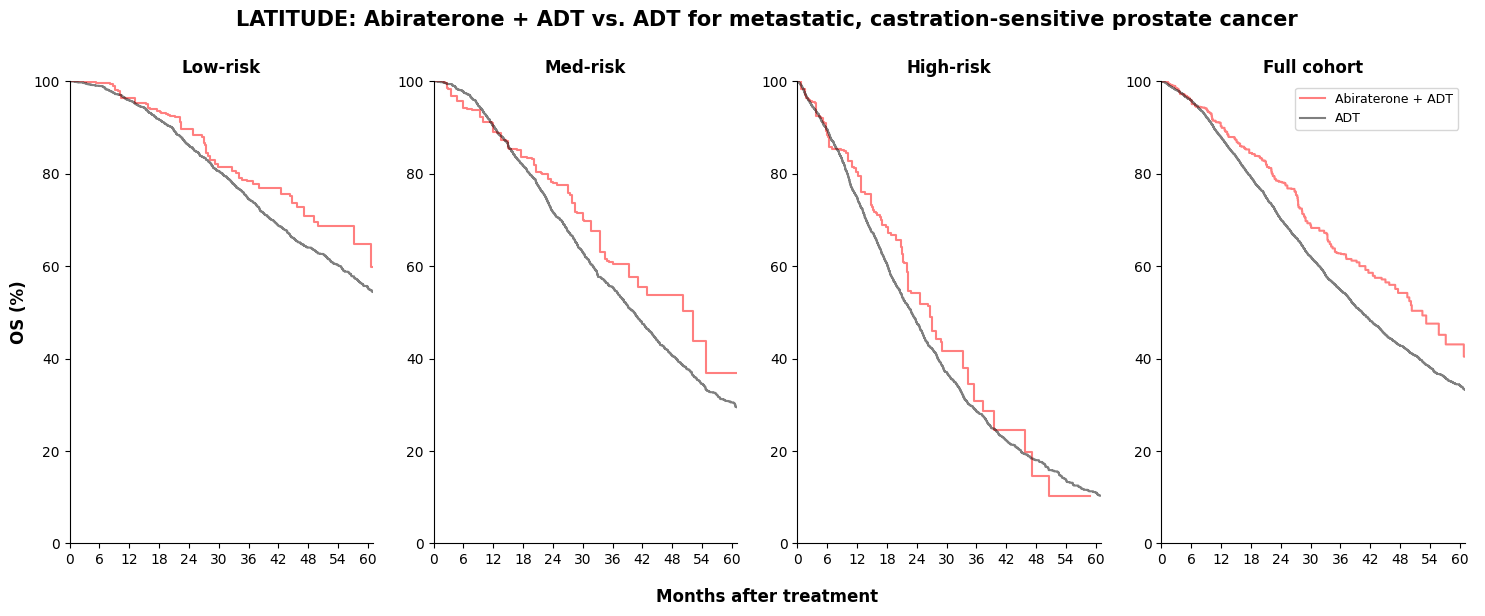

In [229]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_abi_latitude_iptw.timeline, kmf_low_abi_latitude_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_adt_latitude_iptw.timeline, kmf_low_adt_latitude_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_abi_latitude_iptw.timeline, kmf_med_abi_latitude_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_adt_latitude_iptw.timeline, kmf_med_adt_latitude_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_abi_latitude_iptw.timeline, kmf_high_abi_latitude_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_adt_latitude_iptw.timeline, kmf_high_adt_latitude_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_abi_latitude_iptw.timeline, kmf_all_abi_latitude_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Abiraterone + ADT')

plt.step(kmf_all_adt_latitude_iptw.timeline, kmf_all_adt_latitude_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'ADT')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('LATITUDE: Abiraterone + ADT vs. ADT for metastatic, castration-sensitive prostate cancer', pad = 40, size = 15, weight = 'bold')

plt.show()